In [3]:
%cd /home/dev/24/es-bench

/home/dev/24/es-bench


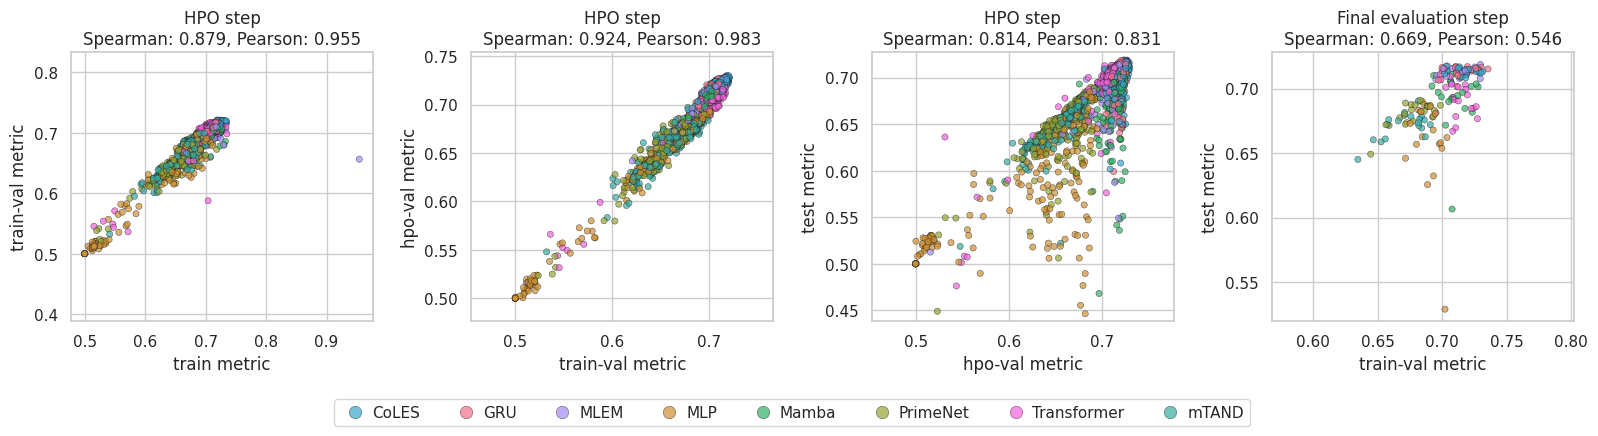

In [5]:
import warnings
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from ebes.pipeline.utils import optuna_df
import random

warnings.filterwarnings("ignore")

method_names = {
    "gru": "GRU",
    "mlp": "MLP",
    "primenet": "PrimeNet",
    "mamba": "Mamba",
    "mtand": "mTAND",
    "coles": "CoLES",
    "mlem": "MLEM",
    "transformer": "Transformer",
}

def determine_metrics_and_pairs_hpo(df):
    metric = [col for col in df if (df[col] == df["value"]).all() and col != "value"]
    assert len(metric) == 1
    metric = metric[0]
    metric = metric.replace("user_attrs_", "").replace("_mean", "")
    if metric == "NegRootMeanSquaredError":
        metric = "R2Score"

    hpo_val = f"user_attrs_{metric}_mean"
    test = f"user_attrs_test_{metric}_mean"
    train = f"user_attrs_train_{metric}_mean"
    train_val = f"user_attrs_train_val_{metric}_mean"

    metrics = {
        train: "train",
        test: "test",
        train_val: "train-val",
        hpo_val: "hpo-val",
    }

    pairs = [
        (train, train_val),
        (train_val, hpo_val),
        (hpo_val, test),
        # (train, train_val),
    ]

    return pairs, metrics

def collect_hpo_data(dataset, methods):
    pair_dict = {}
    color_palette = sns.color_palette("husl", len(methods))
    color_palette = {method_names[methods[i]]: color_palette[i] for i in range(len(methods))}
    
    for method, color in zip(methods, color_palette):
        path = Path(f"log/{dataset}/{method}/optuna")
        df, _ = optuna_df(path)

        df = df.copy()
        df = df[df["state"] == "COMPLETE"]
        q = df["value"].quantile(0.01)
        df = df[df["value"] >= q]
        
        pairs, metrics = determine_metrics_and_pairs_hpo(df)

        for i, (x, y) in enumerate(pairs):
            d = pair_dict.get(i, {"x": [], "y": [], "color": [], "label": []})
            d["x"].extend(df[x].tolist())
            d["y"].extend(df[y].tolist())
            d["color"].extend([color] * df[x].shape[0])
            d["label"].extend([method_names[method]] * df[x].shape[0])
            d["metric_x"] = metrics[x]
            d["metric_y"] = metrics[y]
            pair_dict[i] = d

    for i in pair_dict:
        combined = list(zip(pair_dict[i]["x"], pair_dict[i]["y"], pair_dict[i]["color"], pair_dict[i]["label"]))
        random.shuffle(combined)
        pair_dict[i]["x"], pair_dict[i]["y"], pair_dict[i]["color"], pair_dict[i]["label"] = zip(*combined)


    return pair_dict, color_palette

def plot_hpo_correlation(dataset, methods):
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    pair_dict, color_palette = collect_hpo_data(dataset, methods)
    pair_dict_best, _ = collect_best_data(dataset, methods)
    pair_dict_best = {k + len(pair_dict): v for k, v in pair_dict_best.items()}
    for k in pair_dict_best:
        pair_dict_best[k]["title"] = "Final evaluation step"
    for k in pair_dict:
        pair_dict[k]["title"] = "HPO step"
        
    pair_dict.update(pair_dict_best)
    sns.set(style="whitegrid")
    

    for k in pair_dict:
        x = pd.Series(pair_dict[k]["x"])
        y = pd.Series(pair_dict[k]["y"])
        labels = pair_dict[k]["label"]
        metric_x, metric_y = pair_dict[k]["metric_x"], pair_dict[k]["metric_y"]

        # Use scatter plot with hue for proper color legend
        scatter = sns.scatterplot(ax=ax[k], x=x, y=y, hue=labels, palette=color_palette, s=20, alpha=0.7, edgecolor="k", legend=True)

        spearman = x.corr(y, "spearman")
        pearson = x.corr(y, "pearson")
        ax[k].set_title(f"{pair_dict[k]['title']}\nSpearman: {spearman:.3f}, Pearson: {pearson:.3f}")
        ax[k].set_xlabel(f"{metric_x} metric")
        ax[k].set_ylabel(f"{metric_y} metric")
        ax[k].get_legend().remove()
        ax[k].axis("equal")

    # Create a single global legend
    handles, labels = scatter.get_legend_handles_labels()
    unique_labels = dict(sorted(zip(labels, handles)))
    fig.legend(
        handles=unique_labels.values(), 
        labels=unique_labels.keys(), 
        loc='upper center', 
        ncol=len(methods), 
        bbox_to_anchor=(0.5, -0.0),
        handletextpad=0.1,  # Adjust the space between legend markers and labels
        markerscale=2.0,  # Adjust the scale of the legend markers
    )

    # fig.suptitle(f"{dataset.capitalize()} HPO Correlation", fontsize=16)
    fig.tight_layout()
    path = Path(f"notebooks/paper_plots/figures/hpo_corr/{dataset}.pdf")
    path.parent.mkdir(exist_ok=True, parents=True)
    fig.savefig(path, bbox_inches='tight')
    plt.show()



def determine_metrics_best(df):
    metric = df.columns[0].replace("train_", "")
    if metric == "NegRootMeanSquaredError":
        metric = "R2Score"

    test = f"test_{metric}"
    train = f"train_{metric}"
    train_val = f"train_val_{metric}"

    metrics = {
        train: "train",
        test: "test",
        train_val: "train-val",
    }

    pairs = [
        (train_val, test),
        # (train, test),
    ]
    return metrics, pairs

def collect_best_data(dataset, methods):
    pair_dict = {}
    color_palette = sns.color_palette("husl", len(methods))
    color_palette = {method_names[methods[i]]: color_palette[i] for i in range(len(methods))}
    
    for method, color in zip(methods, color_palette):
        path = Path(f"log/{dataset}/{method}/correlation")
        df = pd.read_csv(path / "results.csv", index_col=0, header=0)
        df = df.T
        df = df.iloc[:-2]

        metrics, pairs = determine_metrics_best(df)
        for i, (x, y) in enumerate(pairs):
            d = pair_dict.get(i, {"x": [], "y": [], "color": [], "label": []})
            d["x"].extend(df[x].tolist())
            d["y"].extend(df[y].tolist())
            d["color"].extend([color] * df[x].shape[0])
            d["label"].extend([method_names[method]] * df[x].shape[0])
            d["metric_x"] = metrics[x]
            d["metric_y"] = metrics[y]
            pair_dict[i] = d

    for i in pair_dict:
        combined = list(zip(pair_dict[i]["x"], pair_dict[i]["y"], pair_dict[i]["color"], pair_dict[i]["label"]))
        random.shuffle(combined)
        pair_dict[i]["x"], pair_dict[i]["y"], pair_dict[i]["color"], pair_dict[i]["label"] = zip(*combined)


    return pair_dict, color_palette

def plot_best_correlation(dataset, methods):
    pair_dict, color_palette = collect_best_data(dataset, methods)
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    for k in pair_dict:
        x = pd.Series(pair_dict[k]["x"])
        y = pd.Series(pair_dict[k]["y"])
        labels = pair_dict[k]["label"]
        metric_x, metric_y = pair_dict[k]["metric_x"], pair_dict[k]["metric_y"]

        # Use scatter plot with hue for proper color legend
        scatter = sns.scatterplot(ax=ax[k], x=x, y=y, hue=labels, palette=color_palette, s=20, alpha=0.7, edgecolor="k", legend=True)

        spearman = x.corr(y, "spearman")
        pearson = x.corr(y, "pearson")
        ax[k].set_title(f"{metric_x} vs {metric_y}\nSpearman: {spearman:.3f}, Pearson: {pearson:.3f}")
        ax[k].set_xlabel(f"{metric_x} metric")
        ax[k].set_ylabel(f"{metric_y} metric")
        ax[k].axis("equal")
        ax[k].get_legend().remove()
    
    # Create a single global legend
    handles, labels = scatter.get_legend_handles_labels()
    unique_labels = dict(sorted(zip(labels, handles)))
    fig.legend(
        handles=unique_labels.values(), 
        labels=unique_labels.keys(), 
        loc='upper center', 
        ncol=len(methods), 
        bbox_to_anchor=(0.5, -0.0),
        handletextpad=0.1,  # Adjust the space between legend markers and labels
        markerscale=2.0  # Adjust the scale of the legend markers
    )

    # fig.suptitle(f"{dataset.capitalize()} HPO Correlation", fontsize=16)
    plt.grid()
    plt.tight_layout()
    path = Path(f"notebooks/paper_plots/figures/best_corr/{dataset}.pdf")
    path.parent.mkdir(exist_ok=True, parents=True)
    plt.savefig(path)
    plt.show()

methods = [
    "gru",
    "mlp",
    "primenet",
    "mamba",
    "mtand",
    "coles",
    "mlem",
    "transformer"
]
datasets = [
    # "physionet2012", 
    # "age", 
    # "x5", 
    # "mimic3", 
    # "pendulum",
    # "mbd",
    "taobao",
]
for dataset in datasets:
    plot_hpo_correlation(dataset, methods)
